In [1]:
import os
import PIL
import scipy.stats
import numpy as np
import nibabel as nib
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from skimage.morphology import erosion
from dipy.core.gradients import gradient_table
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Fit the signal models to phantom and volunteer data

#os.system('python cumulant.py')
#os.system('python higherorder.py')
#os.system('python gamma.py')
#os.system('python qti.py')

In [3]:
# Define plotting parameters

plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 8})
label_font_size = 12
one_column = 3.54
one_half_column = 5.51
two_column = 7.48
dpi = 500

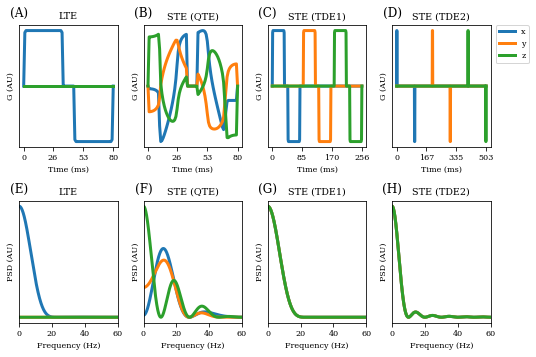

In [4]:
# Create the gradient waveform figure

plt.rcParams['font.family'] = 'serif'

def calc_power(waveform, T, N=int(1e5)):
    """Calculate the power spectrum of a gradient waveform."""
    q = np.cumsum(waveform)
    dt = T / (len(q) - 1)
    ps = np.abs(np.fft.fft(q, N))**2
    freqs = np.fft.fftfreq(N, dt)
    idx = np.argsort(freqs)
    return ps[idx], freqs[idx]

ste = np.loadtxt('../Preproc-data/waveform_STE.txt')
lte = np.loadtxt('../Preproc-data/waveform_LTE.txt')
T = 80e-3
t = np.linspace(0, T * 1e3, lte.shape[0])

n_zeros = 8
tde_1 = np.zeros((lte.shape[0] * 3 + n_zeros * 2, 3))
tde_1[0:78, 0] = lte[:, 0]
tde_1[78 + n_zeros:78 + n_zeros + 78, 1] = lte[:, 0]
tde_1[78 + n_zeros + 78 + n_zeros::, 2] = lte[:, 0]
tde_1_T = 256e-3
tde_1_t = np.linspace(0, tde_1_T * 1e3, tde_1.shape[0])

tde_2 = np.zeros((504, 3))
tde_2[1:3, 0] = 1
tde_2[101:103, 0] = -1
tde_2[201:203, 1] = 1
tde_2[301:303, 1] = -1
tde_2[401:403, 2] = 1
tde_2[501:503, 2] = -1
tde_2_T = 503e-3
tde_2_t = np.linspace(0, tde_2_T * 1e3, tde_2.shape[0])

fig, ax = plt.subplots(2, 4, figsize=(two_column, 5))
for i in range(3):
    ax[0, 0].plot(t, lte[:, i], lw=3)
    ax[0, 1].plot(t, ste[:, i], lw=3)
    ax[0, 2].plot(tde_1_t, tde_1[:, i], lw=3)
    ax[0, 3].plot(tde_2_t, tde_2[:, i], lw=3)
    ps, freqs = calc_power(lte[:, i], T)
    ax[1, 0].plot(freqs, ps, lw=3)
    ps, freqs = calc_power(ste[:, i], T)
    ax[1, 1].plot(freqs, ps, lw=3)
    ps, freqs = calc_power(tde_1[:, 1], tde_1_T)
    ax[1, 2].plot(freqs, ps, lw=3)
    ps, freqs = calc_power(tde_2[:, 1], tde_2_T)
    ax[1, 3].plot(freqs, ps, lw=3)
titles = ['LTE', 'STE (QTE)', 'STE (TDE1)', 'STE (TDE2)']
labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)']
for i in range(4):
    for j in range(2):
        ax[j, i].set_title(titles[i])
        k = j * 4 + i
        ax[j, i].text(-0.0, 1.04, labels[k], verticalalignment='bottom',
                      horizontalalignment='center', fontsize=label_font_size,
                      color='black', transform=ax[j, i].transAxes)
        ax[j, i].set_yticks([])
    ax[0, i].set_xlabel('Time (ms)')
    ax[0, i].set_ylabel('G (AU)')
    ax[1, i].set_xlabel('Frequency (Hz)')
    ax[1, i].set_ylabel('PSD (AU)')
    ax[1, i].set_xlim([0, 60])       
    ax[1, i].set_xticks(np.linspace(0, 60, 4).astype(int))
ax[0, 3].legend(['x', 'y', 'z'], bbox_to_anchor=(1.05, 1),
             loc='upper left', borderaxespad=0.)
ax[0, 0].set_xticks(np.linspace(0, T * 1e3, 4).astype(int))
ax[0, 1].set_xticks(np.linspace(0, T * 1e3, 4).astype(int))
ax[0, 2].set_xticks(np.linspace(0, tde_1_T * 1e3, 4).astype(int))
ax[0, 3].set_xticks(np.linspace(0, tde_2_T * 1e3, 4).astype(int))
fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/waveforms.pdf', dpi=dpi)

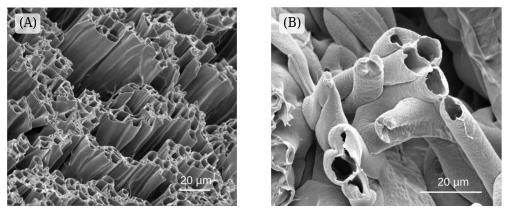

In [5]:
# Create the sem figure

img_1 = np.array(PIL.Image.open('../LaTeX/Figures/parallel_fibres.png'))
img_2 = np.array(PIL.Image.open('../LaTeX/Figures/random_fibres.png'))

fig, ax = plt.subplots(1, 2, figsize=(two_column, 3))
ax[0].imshow(img_1)
ax[1].imshow(img_2)
for i, l in enumerate(['(A)', '(B)']):
    ax[i].axis('off')
    ax[i].text(.05, .95, l, verticalalignment='top',
               horizontalalignment='left', fontsize=label_font_size,
               color='black', transform=ax[i].transAxes,
               bbox=dict(boxstyle='round', fc='white', ec='none', alpha=.75))
fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/phantom_sem.pdf', dpi=dpi)

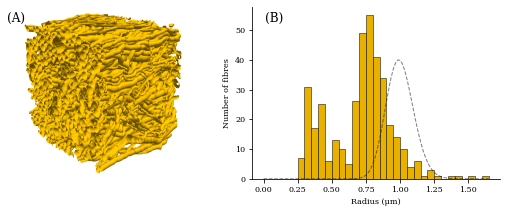

In [6]:
# Create the mesh figure

radii = np.loadtxt('ConFiG/mean_rad.txt')
img = np.array(PIL.Image.open('../LaTeX/Figures/config_mesh.png'))

fig, ax = plt.subplots(1, 2, figsize=(two_column, 3))
ax[0].imshow(img)
ax[0].axis('off')
hs = ax[1].hist(radii, edgecolor='black', color=(233/256, 178/256, 0),
                bins=np.arange(4, 34) / 20, linewidth=.5)
ax[1].set_xlabel('Radius (μm)')
ax[1].set_ylabel('Number of fibres')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].text(-0.05, .975, '(A)', verticalalignment='top',
           horizontalalignment='left', fontsize=label_font_size, color='black',
           transform=ax[0].transAxes)
ax[1].text(0.05, .975, '(B)', verticalalignment='top',
           horizontalalignment='left', fontsize=label_font_size, color='black',
           fontdict={'family' : 'serif'}, transform=ax[1].transAxes)
x = np.linspace(0, 1.65, 100)
ax[1].plot(x, 10 * scipy.stats.gamma.pdf(x, a=100, scale=1/100), lw=1,
           alpha=.5, ls='--', color='black')
#ax = ax[1].twinx()
#ax.set_ylabel('P (AU)', color='tab:orange')
fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/mesh_figure.pdf', dpi=dpi)

In [7]:
# Load volunteer and phantom data

lte_idx = np.arange(107).astype(int)
ste_idx = np.arange(107, 214).astype(int)

vol_data = np.zeros((3, 128, 128, 60, 214))
vol_bvals = np.zeros((3, 214))
vol_bvecs = np.zeros((3, 3, 214))
vol_mask = np.zeros((3, 128, 128, 60))
for i in range(3):
    print('%s/3' % (i + 1), end='\r')
    vol_data[i] = nib.load(
        '../Preproc-data/Volunteer-%s/LTE-STE.nii.gz' % (i + 1)).get_fdata()
    vol_bvals[i] = np.loadtxt(
        '../Preproc-data/Volunteer-%s/LTE-STE.bval' % (i + 1)) * 1e-3
    vol_bvecs[i] = np.loadtxt(
        '../Preproc-data/Volunteer-%s/LTE-STE.bvec' % (i + 1))
    vol_mask[i] = nib.load(
        '../Preproc-data/Volunteer-%s/mask.nii.gz' % (i + 1)).get_fdata()
    for _ in range(2):
        vol_mask[i] = erosion(vol_mask[i])  # Exclude voxels near the skull
    gtab = gradient_table(vol_bvals[i, lte_idx], vol_bvecs[i, :, lte_idx])
    dki_model = dki.DiffusionKurtosisModel(gtab)
    md = dki_model.fit(vol_data[i, :, :, :, 0:107],
                       mask=vol_mask[i].astype(bool)).md
    vol_mask[i] *= (md < 2.5)  # Exclude CSF voxels
vol_mask = vol_mask.astype(bool)

ph_data = nib.load(
    '../Preproc-data/Phantom-avg/LTE-STE.nii.gz').get_fdata()
ph_bvals = np.loadtxt(
    '../Preproc-data/Phantom-avg/LTE-STE.bval')
ph_bvecs = np.loadtxt(
    '../Preproc-data/Phantom-avg/LTE-STE.bvec')
ph_mask = nib.load(
    '../Preproc-data/Phantom-avg/mask.nii.gz').get_fdata().astype(bool)

27.645541107342417


/home/leevi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


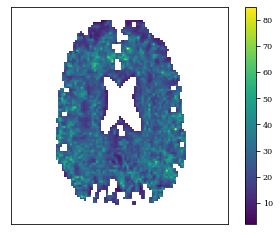

In [8]:
# Estimate SNR at b = 0 in the brain

b0_idx = np.where(vol_bvals[0] == 0)[0]
b0_data = vol_data[..., b0_idx]
for i in range(3):
    b0_data[i, ~vol_mask[i]] = np.nan
snr = np.mean(b0_data, axis=4) / np.std(b0_data, axis=4)
print(np.nanmean(snr))

plt.imshow(np.rot90(snr[0, 14:-14, 14:-14, 33]))
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

123.04623076623433


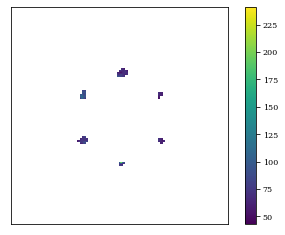

In [9]:
# Estimate SNR at b = 0 in the phantom

b0_data = ph_data[..., b0_idx]
b0_data[~ph_mask] = np.nan
snr = np.mean(b0_data, axis=3) / np.std(b0_data, axis=3)
print(np.nanmean(snr))

plt.imshow(np.rot90(snr[14:-14, 14:-14, 5]))
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

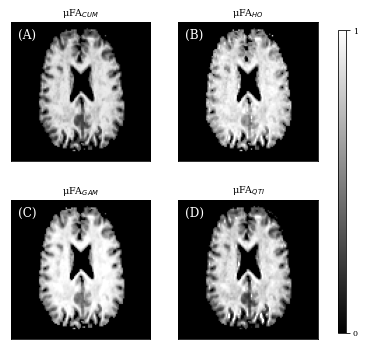

In [10]:
# Create the μFA maps figure

vol_cum_uFA = np.zeros((3, 128, 128, 60))
vol_ho_uFA = np.zeros((3, 128, 128, 60))
vol_gam_uFA = np.zeros((3, 128, 128, 60))
vol_qti_uFA = np.zeros((3, 128, 128, 60))

for i in range(3):
    vol_cum_uFA[i] = nib.load(
        '../Results/Volunteer-%s/cum_uFA.nii.gz' % (i + 1)).get_fdata()
    vol_ho_uFA[i] = nib.load(
        '../Results/Volunteer-%s/ho_uFA.nii.gz' % (i + 1)).get_fdata()
    vol_gam_uFA[i] = nib.load(
        '../Results/Volunteer-%s/gam_uFA.nii.gz' % (i + 1)).get_fdata()
    vol_qti_uFA[i] = nib.load(
        '../Results/Volunteer-%s/qti_uFA.nii.gz' % (i + 1)).get_fdata()

vol_cum_uFA[~vol_mask] = np.nan
vol_ho_uFA[~vol_mask] = np.nan
vol_gam_uFA[~vol_mask] = np.nan
vol_qti_uFA[~vol_mask] = np.nan
vol_cum_uFA[np.isnan(vol_cum_uFA)] = 0
vol_ho_uFA[np.isnan(vol_ho_uFA)] = 0
vol_gam_uFA[np.isnan(vol_gam_uFA)] = 0
vol_qti_uFA[np.isnan(vol_qti_uFA)] = 0

k = 33
vmin = 0
vmax = 1
fig, ax = plt.subplots(2, 2, figsize=(one_half_column, 6))
ax[0, 0].imshow(np.rot90(vol_cum_uFA[0, 14:-14, 14:-14, k]), vmin=vmin,
                vmax=vmax, cmap='gray')
ax[0, 1].imshow(np.rot90(vol_ho_uFA[0, 14:-14, 14:-14, k]), vmin=vmin,
                vmax=vmax, cmap='gray')
ax[1, 0].imshow(np.rot90(vol_gam_uFA[0, 14:-14, 14:-14, k]), vmin=vmin,
                vmax=vmax, cmap='gray')
im = ax[1, 1].imshow(np.rot90(vol_qti_uFA[0, 14:-14, 14:-14, k]), vmin=vmin,
                     vmax=vmax, cmap='gray')
labels = ['(A)', '(B)', '(C)', '(D)']
titles = ['μFA$_{CUM}$', 'μFA$_{HO}$', 'μFA$_{GAM}$', 'μFA$_{QTI}$']
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, .7])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[vmin, vmax])
cbar.set_ticks([vmin, vmax])
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        k = i * 2 + j
        ax[i,j].text(.05, .95, labels[k], verticalalignment='top',
                     horizontalalignment='left', fontsize=label_font_size,
                     color='white', transform=ax[i, j].transAxes)
        ax[i,j].set_title(titles[k])
plt.show()
fig.savefig('../LaTeX/Figures/uFA_maps.pdf', bbox_inches="tight", dpi=dpi)

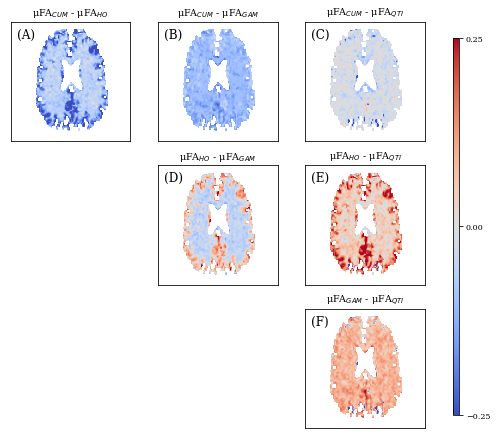

In [11]:
# Create the map comparison figure

k = 33
vmin = -.25
vmax = .25
cmap = 'coolwarm'

vol_cum_uFA[~vol_mask] = np.nan
vol_ho_uFA[~vol_mask] = np.nan
vol_gam_uFA[~vol_mask] = np.nan
vol_qti_uFA[~vol_mask] = np.nan

fig, ax = plt.subplots(3, 3, figsize=(two_column, two_column))
diff = vol_cum_uFA[0, 14:-14, 14:-14, k] - vol_ho_uFA[0, 14:-14, 14:-14, k]
im = ax[0, 0].imshow(np.rot90(diff), vmin=vmin, vmax=vmax, cmap=cmap)
ax[0, 0].set_title('μFA$_{CUM}$ - μFA$_{HO}$')
diff = vol_cum_uFA[0, 14:-14, 14:-14, k] - vol_gam_uFA[0, 14:-14, 14:-14, k]
ax[0, 1].imshow(np.rot90(diff), vmin=vmin, vmax=vmax, cmap=cmap)
ax[0, 1].set_title('μFA$_{CUM}$ - μFA$_{GAM}$')
diff = vol_cum_uFA[0, 14:-14, 14:-14, k] - vol_qti_uFA[0, 14:-14, 14:-14, k]
ax[0, 2].imshow(np.rot90(diff), vmin=vmin, vmax=vmax, cmap=cmap)
ax[0, 2].set_title('μFA$_{CUM}$ - μFA$_{QTI}$')
diff = vol_ho_uFA[0, 14:-14, 14:-14, k] - vol_gam_uFA[0, 14:-14, 14:-14, k]
ax[1, 1].imshow(np.rot90(diff), vmin=vmin, vmax=vmax, cmap=cmap)
ax[1, 1].set_title('μFA$_{HO}$ - μFA$_{GAM}$')
diff = vol_ho_uFA[0, 14:-14, 14:-14, k] - vol_qti_uFA[0, 14:-14, 14:-14, k]
ax[1, 2].imshow(np.rot90(diff), vmin=vmin, vmax=vmax, cmap=cmap)
ax[1, 2].set_title('μFA$_{HO}$ - μFA$_{QTI}$')
diff = vol_gam_uFA[0, 14:-14, 14:-14, k] - vol_qti_uFA[0, 14:-14, 14:-14, k]
ax[2, 2].imshow(np.rot90(diff), vmin=vmin, vmax=vmax, cmap=cmap)
ax[2, 2].set_title('μFA$_{GAM}$ - μFA$_{QTI}$')
for i in range(3):
    for j in range(3):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, .7])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[vmin, 0, vmax])
ax[1, 0].axis('off')
ax[2, 0].axis('off')
ax[2, 1].axis('off')
ax[0, 0].text(.05, .95, '(A)', fontsize=label_font_size,
              verticalalignment='top', horizontalalignment='left',
              transform=ax[0, 0].transAxes)
ax[0, 1].text(.05, .95,'(B)', fontsize=label_font_size,
              verticalalignment='top', horizontalalignment='left',
              transform=ax[0, 1].transAxes)
ax[0, 2].text(.05, .95,'(C)', fontsize=label_font_size,
              verticalalignment='top', horizontalalignment='left',
              transform=ax[0, 2].transAxes)
ax[1, 1].text(.05, .95,'(D)', fontsize=label_font_size,
              verticalalignment='top', horizontalalignment='left',
              transform=ax[1, 1].transAxes)
ax[1, 2].text(.05, .95, '(E)', fontsize=label_font_size,
              verticalalignment='top', horizontalalignment='left',
              transform=ax[1, 2].transAxes)
ax[2, 2].text(.05, .95, '(F)', fontsize=label_font_size,
              verticalalignment='top', horizontalalignment='left',
              transform=ax[2, 2].transAxes)
plt.show()
fig.savefig('../LaTeX/Figures/uFA_map_comparison.pdf', bbox_inches="tight",
            dpi=dpi)

In [12]:
# Calculate concordance correlation coefficient between maps

def calc_ccc(x, y):
    """Calculate Lin's concordance correlation coefficient."""
    x, y = x.ravel(), y.ravel()
    idx = ~np.isnan(x) * ~np.isnan(y)
    x, y = x[idx], y[idx]
    rho = (2 * np.cov(x, y)[0, 1] / 
           (np.var(x) + np.var(y) + (np.mean(x) - np.mean(y))**2))
    return rho

vol_cum_uFA[~vol_mask] = np.nan
vol_ho_uFA[~vol_mask] = np.nan
vol_gam_uFA[~vol_mask] = np.nan
vol_qti_uFA[~vol_mask] = np.nan

print('Concordance coefficients:')
print('CUM-HO: %s' % calc_ccc(vol_cum_uFA, vol_ho_uFA))
print('CUM-GAM: %s' % calc_ccc(vol_cum_uFA, vol_gam_uFA))
print('CUM-QTI: %s' % calc_ccc(vol_cum_uFA, vol_qti_uFA))
print('HO-GAM: %s' % calc_ccc(vol_ho_uFA, vol_gam_uFA))
print('HO-QTI: %s' % calc_ccc(vol_ho_uFA, vol_qti_uFA))
print('GAM-QTI: %s' % calc_ccc(vol_gam_uFA, vol_qti_uFA))

Concordance coefficients:
CUM-HO: 0.6392423450707718
CUM-GAM: 0.8480494856430261
CUM-QTI: 0.9132649190100036
HO-GAM: 0.846329690854637
HO-QTI: 0.6447703597473544
GAM-QTI: 0.8094669842255436


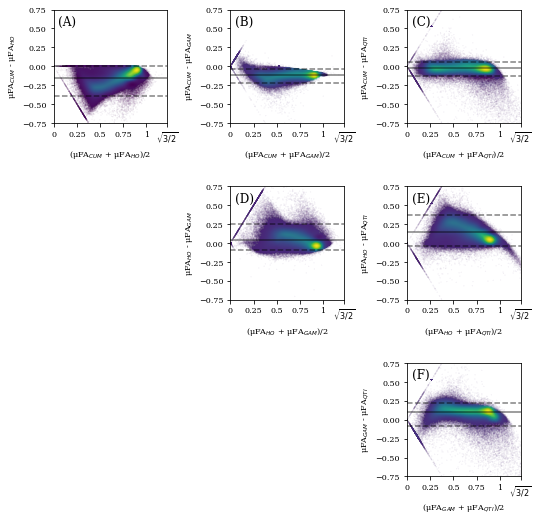

Mean uFA cumulant = 0.5897004812659952
Mean uFA higher order = 0.7496902813335058
Mean uFA gamma = 0.7064428613607829
Mean uFA QTI = 0.6093247884507812

Cumulant vs higher order
ll, ul, width = -0.39065301083349013, -6.029713228716809e-10, 0.3906530102305188

Cumulant vs gamma
ll, ul, width = -0.21745242870259401, -0.031572985115129265, 0.18587944358746475

Cumulant vs QTI
ll, ul, width = -0.1330310003384364, 0.0515384069218779, 0.1845694072603143

Higher order vs gamma
ll, ul, width = -0.09402006314730424, 0.2557539218040274, 0.3497739849513316

Higher order vs QTI
ll, ul, width = -0.03749580674239385, 0.37374475312916877, 0.4112405598715626

Gamma vs QTI
ll, ul, width = -0.08068656488365569, 0.22094479664239466, 0.30163136152605036


In [13]:
# Create the voxel-wise comparison figure

def density_scatter(x, y, ax, **kwargs):
    """Create a scatter plot where colour reflects point density."""
    data, x_e, y_e = np.histogram2d(
        x, y, range=[[0, np.sqrt(1.5)], [-np.sqrt(1.5), np.sqrt(1.5)]], bins=30,
        density=True)
    z = interpn((0.5 * (x_e[1:] + x_e[:-1]), 0.5 * (y_e[1:] + y_e[:-1])), data,
                 np.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    ax.scatter(x, y, c=z, **kwargs)
    return

fig, ax = plt.subplots(3, 3, figsize=(two_column, two_column))

y1 = vol_cum_uFA.ravel() - vol_ho_uFA.ravel()
x1 = (vol_cum_uFA.ravel() + vol_ho_uFA.ravel()) / 2
idx = ~np.isnan(x1 * y1)
x1, y1 = x1[idx], y1[idx]
a1 = vol_cum_uFA.ravel()[idx]
b1 = vol_ho_uFA.ravel()[idx]
ll1 = np.percentile(y1, 2.5)
ul1 = np.percentile(y1, 97.5)
ax[0, 0].plot([0, np.sqrt(1.5)], [np.mean(y1), np.mean(y1)], color='black',
             alpha=.5)
ax[0, 0].plot([0, np.sqrt(1.5)], [ul1, ul1], ls='--', color='black', alpha=.5)
ax[0, 0].plot([0, np.sqrt(1.5)], [ll1, ll1], ls='--', color='black', alpha=.5)
density_scatter(x1, y1, ax=ax[0, 0], s=.01, alpha=.25)
ax[0, 0].set_ylabel('μFA$_{CUM}$ - μFA$_{HO}$')
ax[0, 0].set_xlabel('(μFA$_{CUM}$ + μFA$_{HO}$)/2')

y2 = vol_cum_uFA.ravel() - vol_gam_uFA.ravel()
x2 = (vol_cum_uFA.ravel() + vol_gam_uFA.ravel()) / 2
idx = ~np.isnan(x2 * y2)
x2, y2 = x2[idx], y2[idx]
a2 = vol_cum_uFA.ravel()[idx]
b2 = vol_gam_uFA.ravel()[idx]
ll2 = np.percentile(y2, 2.5)
ul2 = np.percentile(y2, 97.5)
ax[0, 1].plot([0, np.sqrt(1.5)], [np.mean(y2), np.mean(y2)], color='black',
             alpha=.5)
ax[0, 1].plot([0, np.sqrt(1.5)], [ul2, ul2], ls='--', color='black', alpha=.5)
ax[0, 1].plot([0, np.sqrt(1.5)], [ll2, ll2], ls='--', color='black', alpha=.5)
density_scatter(x2, y2, ax=ax[0, 1], s=.01, alpha=.25)
ax[0, 1].set_ylabel('μFA$_{CUM}$ - μFA$_{GAM}$')
ax[0, 1].set_xlabel('(μFA$_{CUM}$ + μFA$_{GAM}$)/2')

y3 = vol_cum_uFA.ravel() - vol_qti_uFA.ravel()
x3 = (vol_cum_uFA.ravel() + vol_qti_uFA.ravel()) / 2
idx = ~np.isnan(x3 * y3)
x3, y3 = x3[idx], y3[idx]
a3 = vol_cum_uFA.ravel()[idx]
b3 = vol_qti_uFA.ravel()[idx]
ll3 = np.percentile(y3, 2.5)
ul3 = np.percentile(y3, 97.5)
ax[0, 2].plot([0, np.sqrt(1.5)], [np.mean(y3), np.mean(y3)], color='black',
             alpha=.5)
ax[0, 2].plot([0, np.sqrt(1.5)], [ul3, ul3], ls='--', color='black', alpha=.5)
ax[0, 2].plot([0, np.sqrt(1.5)], [ll3, ll3], ls='--', color='black', alpha=.5)
density_scatter(x3, y3, ax=ax[0, 2], s=.01, alpha=.25)
ax[0, 2].set_ylabel('μFA$_{CUM}$ - μFA$_{QTI}$')
ax[0, 2].set_xlabel('(μFA$_{CUM}$ + μFA$_{QTI}$)/2')

y4 = vol_ho_uFA.ravel() - vol_gam_uFA.ravel()
x4 = (vol_ho_uFA.ravel() + vol_gam_uFA.ravel()) / 2
idx = ~np.isnan(x4 * y4)
x4, y4 = x4[idx], y4[idx]
a4 = vol_ho_uFA.ravel()[idx]
b4 = vol_gam_uFA.ravel()[idx]
ll4 = np.percentile(y4, 2.5)
ul4 = np.percentile(y4, 97.5)
ax[1, 1].plot([0, np.sqrt(1.5)], [np.mean(y4), np.mean(y4)], color='black',
             alpha=.5)
ax[1, 1].plot([0, np.sqrt(1.5)], [ul4, ul4], ls='--', color='black', alpha=.5)
ax[1, 1].plot([0, np.sqrt(1.5)], [ll4, ll4], ls='--', color='black', alpha=.5)
density_scatter(x4, y4, ax=ax[1, 1], s=.01, alpha=.25)
ax[1, 1].set_ylabel('μFA$_{HO}$ - μFA$_{GAM}$')
ax[1, 1].set_xlabel('(μFA$_{HO}$ + μFA$_{GAM}$)/2')

y5 = vol_ho_uFA.ravel() - vol_qti_uFA.ravel()
x5 = (vol_ho_uFA.ravel() + vol_qti_uFA.ravel()) / 2
idx = ~np.isnan(x5 * y5)
x5, y5 = x5[idx], y5[idx]
a5 = vol_ho_uFA.ravel()[idx]
b5 = vol_qti_uFA.ravel()[idx]
ll5 = np.percentile(y5, 2.5)
ul5 = np.percentile(y5, 97.5)
ax[1, 2].plot([0, np.sqrt(1.5)], [np.mean(y5), np.mean(y5)], color='black',
             alpha=.5)
ax[1, 2].plot([0, np.sqrt(1.5)], [ul5, ul5], ls='--', color='black', alpha=.5)
ax[1, 2].plot([0, np.sqrt(1.5)], [ll5, ll5], ls='--', color='black', alpha=.5)
density_scatter(x5, y5, ax=ax[1, 2], s=.01, alpha=.25)
ax[1, 2].set_ylabel('μFA$_{HO}$ - μFA$_{QTI}$')
ax[1, 2].set_xlabel('(μFA$_{HO}$ + μFA$_{QTI}$)/2')

y6 = vol_gam_uFA.ravel() - vol_qti_uFA.ravel()
x6 = (vol_gam_uFA.ravel() + vol_qti_uFA.ravel()) / 2
idx = ~np.isnan(x6 * y6)
x6, y6 = x6[idx], y6[idx]
a6 = vol_gam_uFA.ravel()[idx]
b6 = vol_qti_uFA.ravel()[idx]
ll6 = np.percentile(y6, 2.5)
ul6 = np.percentile(y6, 97.5)
ax[2, 2].plot([0, np.sqrt(1.5)], [np.mean(y6), np.mean(y6)], color='black',
             alpha=.5)
ax[2, 2].plot([0, np.sqrt(1.5)], [ul6, ul6], ls='--', color='black', alpha=.5)
ax[2, 2].plot([0, np.sqrt(1.5)], [ll6, ll6], ls='--', color='black', alpha=.5)
density_scatter(x6, y6, ax=ax[2, 2], s=.01, alpha=.25)
ax[2, 2].set_ylabel('μFA$_{GAM}$ - μFA$_{QTI}$')
ax[2, 2].set_xlabel('(μFA$_{GAM}$ + μFA$_{QTI}$)/2')

for i in range(3):
    for j in range(i, 3):
        ax[i, j].set_aspect(np.sqrt(1.5) / 1.5)
        ax[i, j].set_xlim([0, np.sqrt(1.5)])
        ax[i, j].set_ylim([-.75, .75])
        ax[i, j].set_xticks([0, .25, .5, .75, 1, np.sqrt(1.5)])
        ax[i, j].set_xticklabels(['0', '0.25', '0.5', '0.75', '1', 
                                  '$\sqrt{3/2}$'])
        ax[i, j].set_yticks([-.75, -.5, -.25, 0, .25, .5, .75])
ax[1, 0].axis('off')
ax[2, 0].axis('off')
ax[2, 1].axis('off')
ax[0, 0].text(.05, .675, '(A)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left')
ax[0, 1].text(.05, .675,'(B)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left')
ax[0, 2].text(.05, .675,'(C)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left')
ax[1, 1].text(.05, .675,'(D)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left')
ax[1, 2].text(.05, .675, '(E)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left')
ax[2, 2].text(.05, .675, '(F)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left')

fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/ba_plots.png', dpi=dpi)

print('Mean uFA cumulant = %s' % np.nanmean(vol_cum_uFA))
print('Mean uFA higher order = %s' % np.nanmean(vol_ho_uFA))
print('Mean uFA gamma = %s' % np.nanmean(vol_gam_uFA))
print('Mean uFA QTI = %s' % np.nanmean(vol_qti_uFA))
print('\nCumulant vs higher order')
print('ll, ul, width = %s, %s, %s' % (ll1, ul1, abs(ll1 - ul1)))
print('\nCumulant vs gamma')
print('ll, ul, width = %s, %s, %s' % (ll2, ul2, abs(ll2 - ul2)))
print('\nCumulant vs QTI')
print('ll, ul, width = %s, %s, %s' % (ll3, ul3, abs(ll3 - ul3)))
print('\nHigher order vs gamma')
print('ll, ul, width = %s, %s, %s' % (ll4, ul4, abs(ll4 - ul4)))
print('\nHigher order vs QTI')
print('ll, ul, width = %s, %s, %s' % (ll5, ul5, abs(ll5 - ul5)))
print('\nGamma vs QTI')
print('ll, ul, width = %s, %s, %s' % (ll6, ul6, abs(ll6 - ul6)))

Volunteer: R = 0.3555815047908063 (p = 0.0)
Phantom: R = 0.3366170326848582 (p = 3.1387053857505925e-17)


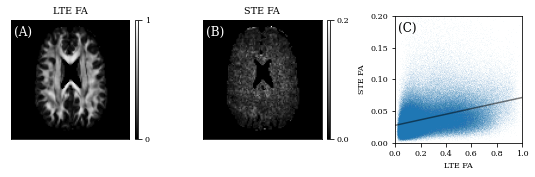

In [14]:
# Quantify orientational variance of the STE acquisition

vol_lte_fa = np.zeros((3, 128, 128, 60))
vol_ste_fa = np.zeros((3, 128, 128, 60))
for i in range(3):
    gtab = gradient_table(vol_bvals[i, lte_idx], vol_bvecs[i, :, lte_idx])
    dti_model = dti.TensorModel(gtab)
    dti_fit = dti_model.fit(vol_data[i, :, :, :, 0:107], mask=vol_mask[i])
    vol_lte_fa[i] = dti_fit.fa
    gtab = gradient_table(vol_bvals[i, ste_idx], vol_bvecs[i, :, ste_idx])
    dti_model = dti.TensorModel(gtab)
    dti_fit = dti_model.fit(vol_data[i, :, :, :, 107::], mask=vol_mask[i])
    vol_ste_fa[i] = dti_fit.fa
vol_x, vol_y = vol_lte_fa[vol_mask].ravel(), vol_ste_fa[vol_mask].ravel()
idx = (vol_x != 0) * (vol_y != 0)
vol_x, vol_y = vol_x[idx], vol_y[idx]
print('Volunteer: R = %s (p = %s)' % scipy.stats.pearsonr(vol_x, vol_y))

ph_lte_fa = np.zeros((128, 128, 10))
ph_ste_fa = np.zeros((128, 128, 10))
ph_gtab = gradient_table(ph_bvals[lte_idx], ph_bvecs[:, lte_idx])
dti_model = dti.TensorModel(gtab)
dti_fit = dti_model.fit(ph_data[:, :, :, 0:107], mask=ph_mask)
ph_lte_fa = dti_fit.fa
gtab = gradient_table(ph_bvals[ste_idx], ph_bvecs[:, ste_idx])
dti_model = dti.TensorModel(gtab)
dti_fit = dti_model.fit(ph_data[:, :, :, 107::], mask=ph_mask)
ph_ste_fa = dti_fit.fa
ph_x, ph_y = ph_lte_fa.ravel(), ph_ste_fa.ravel()
idx = (ph_x != 0) * (ph_y != 0)
ph_x, ph_y = ph_x[idx], ph_y[idx]
print('Phantom: R = %s (p = %s)' % scipy.stats.pearsonr(ph_x, ph_y))

fig, ax = plt.subplots(1, 3, figsize=(two_column, two_column / 3))
k = 33
im = ax[0].imshow(np.rot90(vol_lte_fa[0, 14:-14, 14:-14, k]), vmin=0, vmax=1,
                  cmap='gray')
divider = make_axes_locatable(ax[0])
cbar = plt.colorbar(im, cax=divider.append_axes("right", size="2.5%",
                                                pad=0.075))
cbar.set_ticks([0, 1])
im = ax[1].imshow(np.rot90(vol_ste_fa[0, 14:-14, 14:-14, k]), vmin=0, vmax=.2,
                  cmap='gray')
divider = make_axes_locatable(ax[1])
cbar = plt.colorbar(im, cax=divider.append_axes("right", size="2.5%",
                                                pad=0.075))
cbar.set_ticks([0, .2])
for i, title in enumerate(['LTE FA', 'STE FA']):
    ax[i].set_title(title)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
ax[2].scatter(vol_x, vol_y, s=.01, alpha=.1)
m, b = np.polyfit(vol_x, vol_y, 1)
ax[2].plot(np.array([0, 1]), m * np.array([0, 1]) + b, color='black', alpha=.5)
ax[2].set_xlim([0, 1])
ax[2].set_ylim([0, .2])
ax[2].set_xlabel('LTE FA')
ax[2].set_ylabel('STE FA')
ax[2].set_aspect(5)
ax[0].text(.025, .95, '(A)', verticalalignment='top',
           horizontalalignment='left', fontsize=label_font_size, color='white',
           transform=ax[0].transAxes)
ax[1].text(.025, .95, '(B)', verticalalignment='top',
           horizontalalignment='left', fontsize=label_font_size, color='white',
           transform=ax[1].transAxes)
ax[2].text(.025, .95, '(C)', verticalalignment='top',
           horizontalalignment='left', fontsize=label_font_size, color='black',
           transform=ax[2].transAxes)
fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/FA_figure.png', bbox_inches="tight", dpi=dpi)

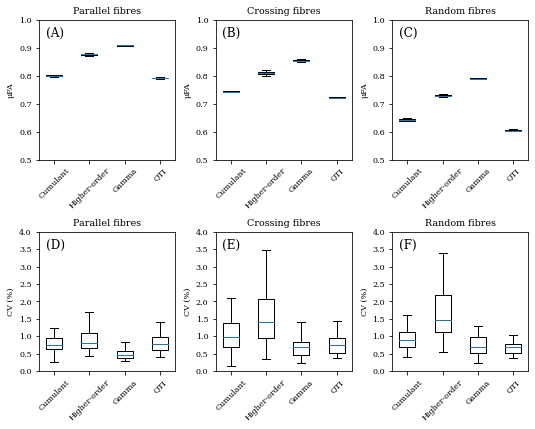

In [15]:
# Create the phantom figure

ph_cum_uFA = np.zeros((128, 128, 10, 11))
ph_ho_uFA = np.zeros((128, 128, 10, 11))
ph_gam_uFA = np.zeros((128, 128, 10, 11))
ph_qti_uFA = np.zeros((128, 128, 10, 11))

for i in range(11):
    ph_cum_uFA[:, :, :, i] = nib.load(
        '../Results/Phantom-%s/cum_uFA.nii.gz' % (i + 1)).get_fdata()
    ph_ho_uFA[:, :, :, i] = nib.load(
        '../Results/Phantom-%s/ho_uFA.nii.gz' % (i + 1)).get_fdata()
    ph_gam_uFA[:, :, :, i] = nib.load(
        '../Results/Phantom-%s/gam_uFA.nii.gz' % (i + 1)).get_fdata()
    ph_qti_uFA[:, :, :, i] = nib.load(
        '../Results/Phantom-%s/qti_uFA.nii.gz' % (i + 1)).get_fdata()
ROI_para = nib.load(
    '../Preproc-data/phantom_para_mask.nii.gz').get_fdata().astype(bool)
ROI_cros = nib.load(
    '../Preproc-data/phantom_cros_mask.nii.gz').get_fdata().astype(bool)
ROI_rand = nib.load(
    '../Preproc-data/phantom_rand_mask.nii.gz').get_fdata().astype(bool)

fig, ax = plt.subplots(2, 3, figsize=(two_column, 6))
pos = [0, .7, 1.4, 2.1]
mu = .25 * (np.mean(ph_cum_uFA[ph_mask])
            + np.mean(ph_ho_uFA[ph_mask])
            + np.mean(ph_gam_uFA[ph_mask])
            + np.mean(ph_qti_uFA[ph_mask]))
for i, roi in enumerate([ROI_para, ROI_cros, ROI_rand]):
    ax[0, i].boxplot([np.mean(ph_cum_uFA[roi], axis=0),
                      np.mean(ph_ho_uFA[roi], axis=0),
                      np.mean(ph_gam_uFA[roi], axis=0),
                      np.mean(ph_qti_uFA[roi], axis=0)],
                     positions=pos,
                     medianprops={'color' : 'tab:blue'},
                     showfliers=False)
    ax[1, i].boxplot([100 * np.std(ph_cum_uFA[roi], axis=1) / mu,
                      100 * np.std(ph_ho_uFA[roi], axis=1) / mu,
                      100 * np.std(ph_gam_uFA[roi], axis=1) / mu,
                      100 * np.std(ph_qti_uFA[roi], axis=1) / mu],
                     positions=pos,
                     medianprops={'color' : 'tab:blue'},
                     showfliers=False)
    ax[0, i].set_ylim([.5, 1])
    ax[0, i].set_ylabel('μFA')
    ax[1, i].set_ylim([0, 4])
    ax[1, i].set_ylabel('CV (%)')

titles = ['Parallel fibres', 'Crossing fibres', 'Random fibres']
labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)']
for i in range(2):
    for j in range(3):
        ax[i, j].set_title(titles[j])
        ax[i, j].set_xticks(pos)
        ax[i, j].set_xlim([-.3, 2.4])
        k = i * 3 + j
        ax[i, j].text(0.05, 0.95, labels[k], verticalalignment='top',
                      horizontalalignment='left', transform=ax[i, j].transAxes,
                      size=label_font_size)
        ax[i, j].set_xticklabels(['Cumulant', 'Higher-order', 'Gamma', 'QTI'],
                                 rotation=45)
fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/phantom_results.pdf')

In [16]:
# Quantify the effect of PRNG seed

path = '../Preproc-data'
signals = np.zeros((5, 214))
for i, s in enumerate([10, 20, 30, 40]):
    signals[i] = np.nanmean(np.load(
        os.path.join(path, 'simulated_signals_1_seed%s.npy' % s)), axis=1)
signals[4] = np.nanmean(np.load(
    os.path.join(path, 'simulated_signals_1.npy')), axis=1)
#signals[np.isnan(signals)] = 1
snr = 1 / np.mean(np.std(signals, axis=0))
print('SNR = %s' % snr)

SNR = 5026.812567702643


In [17]:
# Load simulated signals

path = '../Preproc-data'
signals = np.zeros((3, 382, 214))
for i in range(3):  # Load signals from 3 simulations
    temp_signals = np.load(
        os.path.join(path, 'simulated_signals_%s.npy' % (i + 1)))
    for j in range(381):  # Load intra-axonal signals
        signals[i, j + 1] = np.nanmean(
            temp_signals[:, int(j*5e3):int((j+1)*5e3)], axis=1)
    signals[i, 0] = np.nanmean(
        temp_signals[:, int(1905e3)::], axis=1)  # Load extra-axonal signal
total_signals = np.zeros((3, 3, 214))
fs_ic = [.2, .6, 1]  # Intra-axonal signal fractions
weights = np.zeros((3, 382))
for i in range(3):
    for j, w in enumerate(fs_ic):
        weights[j] = np.ones(382) * w / 381
        weights[j, 0] = 1 - w
        total_signals[i, j] = np.sum(
            weights[j, :, np.newaxis] * signals[i], axis=0)

In [18]:
# Calculate ground-truth uFA

gt_uFA = np.zeros((3, 3))
bvals = np.loadtxt('../Preproc-data/Phantom-avg/LTE-STE.bval')[0:107] * 1e-3
bvals = np.concatenate([bvals, bvals])
bs = np.unique(bvals)
bvecs = np.loadtxt('../Preproc-data/Phantom-avg/LTE-STE.bvec')[:, 0:107].T
bvecs = np.concatenate([bvecs, bvecs], axis=0)
gtab = gradient_table(bvals[lte_idx], bvecs[lte_idx])
dki_model = dki.DiffusionKurtosisModel(gtab)
for i in range(3):  # Simulations 1, 2, 3
    for j in range(3):  # Intra-axonal signal fractions
        evals = np.zeros((382, 3))
        for k in range(382):
            evals[k] = dki_model.fit(signals[i, k, lte_idx]).evals
        avg_eval_var = np.sum(weights[j] * np.var(evals, axis=1))
        avg_md_sq = np.sum(weights[j] * np.mean(evals, axis=1)**2)
        gt_uFA[i, j] = np.sqrt(1.5 * avg_eval_var / (avg_eval_var + avg_md_sq))
print('\nGround truth:\n%s' % gt_uFA)


Ground truth:
[[0.33624246 0.59031848 0.97027678]
 [0.33560717 0.58975487 0.96976039]
 [0.33797236 0.59369494 0.97812535]]


In [19]:
# Add noise to data and calculate uFA

SNR = 25
N = int(1e4)
np.random.seed(123)

import cumulant
import higherorder
import gamma
import qti

def fit_uFAs(signals):
    pa_lte = gamma.calc_pa(signals[lte_idx], bvals[lte_idx])
    pa_ste = gamma.calc_pa(signals[ste_idx], bvals[ste_idx])
    x = cumulant.fit_cum_model(pa_lte, pa_ste, np.unique(bvals))
    cum_uFA = cumulant.calc_uFA(x[1], x[3], x[2])
    x = higherorder.fit_ho_model(pa_lte, pa_ste, np.unique(bvals))
    ho_uFA = higherorder.calc_uFA(x[1], x[3], x[2])
    x = gamma.fit_gamma_model(pa_lte, pa_ste, np.unique(bvals))
    gam_uFA = gamma.calc_uFA(x[1], x[3], x[2])
    X = qti.calc_design_matrix(bvecs[lte_idx], bvals[lte_idx],
                               bvecs[ste_idx], bvals[ste_idx])
    S0_hat, D_hat, C_hat = qti.fit_qti(
        np.concatenate([signals[lte_idx], signals[ste_idx]]), X)
    qti_uFA = qti.calc_uFA(D_hat, C_hat)  
    return cum_uFA, ho_uFA, gam_uFA, qti_uFA

sim_cum_uFA = np.zeros((3, 3, N))
sim_gam_uFA = np.zeros((3, 3, N))
sim_ho_uFA = np.zeros((3, 3, N))
sim_qti_uFA = np.zeros((3, 3, N))
for i in range(3):
    for j in range(3):
        for k in range(N):
            print('%s/%s' % (i * (3 * N) + j * N + k, N * 3 * 3), end='\r')
            sigma = np.max(total_signals[i, j]) / SNR
            noisy_signals = np.abs(
                total_signals[i, j] + np.random.normal(
                    size=total_signals[i, j].shape, scale=sigma, loc=0)
                + 1j * np.random.normal(size=total_signals[i, j].shape,
                                        scale=sigma, loc=0)) * 1e3
            (sim_cum_uFA[i, j, k], sim_ho_uFA[i, j, k], sim_gam_uFA[i, j, k],
             sim_qti_uFA[i ,j, k]) = fit_uFAs(noisy_signals)

print('Cumulant MSE: %s' % np.mean(
    (np.mean(sim_cum_uFA, axis=2)[2] - gt_uFA[2])**2))
print('Higher-order MSE: %s' % np.mean(
    (np.mean(sim_ho_uFA, axis=2)[2] - gt_uFA[2])**2))
print('Gamma MSE: %s' % np.mean(
    (np.mean(sim_gam_uFA, axis=2)[2] - gt_uFA[2])**2))
print('QTI MSE: %s' % np.mean(
    (np.nanmean(sim_qti_uFA, axis=2)[2] - gt_uFA[2])**2))
print('\nCumulant CV: %s' % (np.mean(
    np.std(sim_cum_uFA, axis=2)) / np.mean(gt_uFA) * 100))
print('Higher-order CV: %s' % (np.mean(
    np.std(sim_ho_uFA, axis=2)) / np.mean(gt_uFA) * 100))
print('Gamma CV: %s' % (np.mean(
    np.std(sim_gam_uFA, axis=2)) / np.mean(gt_uFA) * 100))
print('QTI CV: %s' % (np.mean(
    np.nanstd(sim_qti_uFA, axis=2)) / np.mean(gt_uFA) * 100))
print('\nCumulant S1-S3: %s' % (np.nanmean(
    sim_cum_uFA, axis=2)[0] - np.nanmean(sim_cum_uFA, axis=2)[2]))
print('Higher-order S1-S3: %s' % (np.nanmean(
    sim_ho_uFA, axis=2)[0] - np.nanmean(sim_ho_uFA, axis=2)[2]))
print('Gamma S1-S3: %s' % (np.nanmean(
    sim_gam_uFA, axis=2)[0] - np.nanmean(sim_gam_uFA, axis=2)[2]))
print('QTI S1-S3: %s' % (np.nanmean(
    sim_qti_uFA, axis=2)[0] - np.nanmean(sim_qti_uFA, axis=2)[2]))

/home/leevi/Dropbox/PhD/QTE/Publication/Code/qti.py:134: RuntimeWarning: invalid value encountered in sqrt
  from_6x6_to_21x1(E_iso)))


Cumulant MSE: 0.0018116264370751235
Higher-order MSE: 0.005384369973765415
Gamma MSE: 0.012741617457104911
QTI MSE: 0.0015887138032409738

Cumulant CV: 6.605827438770497
Higher-order CV: 10.644774440670938
Gamma CV: 6.603446159510735
QTI CV: 8.467663654493744

Cumulant S1-S3: [0.10674071 0.08420996 0.03984759]
Higher-order S1-S3: [0.11169904 0.09505028 0.05025421]
Gamma S1-S3: [0.1282689  0.08807271 0.04590914]
QTI S1-S3: [0.10101723 0.08403396 0.03866169]


In [20]:
# Repeat the above while allowing P_3 to be negative

sim_ho_uFA_2 = np.zeros((3, 3, N))
for i in range(3):
    for j in range(3):
        for k in range(N):
            print('%s/%s' % (i * (3 * N) + j * N + k, N * 3 * 3), end='\r')
            sigma = np.max(total_signals[i, j]) / SNR
            noisy_signals = np.abs(
                total_signals[i, j] + np.random.normal(
                    size=total_signals[i, j].shape, scale=sigma, loc=0)
                + 1j * np.random.normal(size=total_signals[i, j].shape,
                                        scale=sigma, loc=0)) * 1e3
            pa_lte = gamma.calc_pa(noisy_signals[lte_idx], bvals[lte_idx])
            pa_ste = gamma.calc_pa(noisy_signals[ste_idx], bvals[ste_idx])
            x = higherorder.fit_ho_model(pa_lte, pa_ste, np.unique(bvals),
                                         bounds=([0, 0, 0, 0, -np.inf],
                                                 [np.inf for i in range(5)]))
            sim_ho_uFA_2[i, j, k] = higherorder.calc_uFA(x[1], x[3], x[2])

print('MSE: %s' % np.mean((np.mean(sim_ho_uFA_2, axis=2)[2] - gt_uFA[2])**2))
print('CV: %s' % (np.mean(np.std(sim_ho_uFA_2, axis=2)) / np.mean(gt_uFA) * 100))

MSE: 0.0019974305473902366
CV: 24.08242479534038


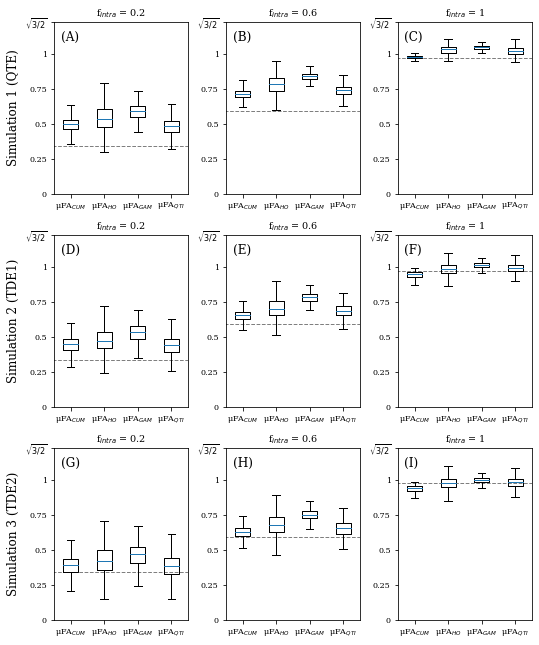

In [21]:
# Create figure and print results

fig, ax = plt.subplots(3, 3, figsize=(two_column, 9))
pos = [0, .7, 1.4, 2.1]
for i in range(3):
    for j in range(3):
        ax[i, j].boxplot([sim_cum_uFA[i, j],
                          sim_ho_uFA[i, j],
                          sim_gam_uFA[i, j], 
                          sim_qti_uFA[i, j][~np.isnan(sim_qti_uFA[i, j])]],
                         positions=pos, medianprops = {'color' : 'tab:blue'},
                         showfliers=False)
        ax[i, j].plot([-.5, 2.5], [gt_uFA[i, j], gt_uFA[i, j]],
                      ls='--', color='black', lw=1, alpha=.5)
labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)', '(I)']
encoding = ['Simulation 1 (QTE)', 'Simulation 2 (TDE1)', 'Simulation 3 (TDE2)']
for i in range(3):
    for j in range(3):
        k = i * 3 + j
        ax[i,j].set_xlim([-.35, 2.45])
        ax[i,j].set_yticks(np.concatenate([np.linspace(0, 1, 5),
                                           [np.sqrt(1.5)]]))
        ax[i,j].set_yticklabels(['0', '0.25', '0.5', '0.75', '1',
                                 '$\sqrt{3/2}$'])
        ax[i,j].set_xticks(pos)
        ax[i,j].set_xticklabels(['μFA$_{CUM}$', 'μFA$_{HO}$', 'μFA$_{GAM}$',
                               'μFA$_{QTI}$'])
        ax[i, j].set_title('f$_{intra}$ = %s' % fs_ic[j])
        ax[i, j].text(0.05, 0.95, labels[k], verticalalignment='top',
                      horizontalalignment='left', fontsize=label_font_size,
                      transform=ax[i, j].transAxes)
    ax[i, 0].text(-0.3, 0.5, encoding[i], verticalalignment='center',
                  horizontalalignment='center', fontsize=label_font_size,
                  rotation=90, transform=ax[i, 0].transAxes)
fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/sim_results.pdf', dpi=dpi)

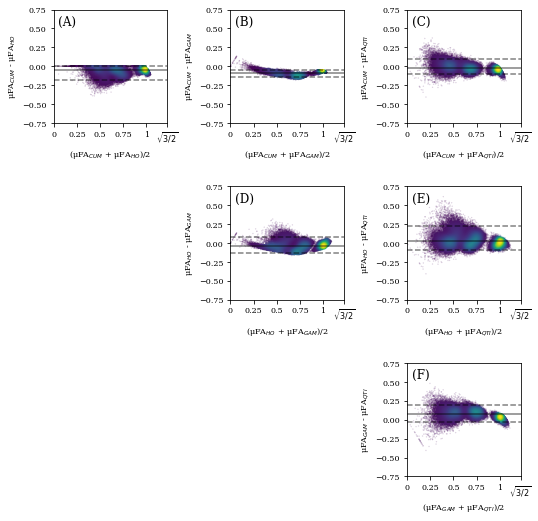

In [22]:
# Create scatter plot of simulation results
    
fig, ax = plt.subplots(3, 3, figsize=(two_column, two_column))

y = sim_cum_uFA.ravel() - sim_ho_uFA.ravel()
x = (sim_cum_uFA.ravel() + sim_ho_uFA.ravel()) / 2
idx = ~np.isnan(x * y)
x, y = x[idx], y[idx]
density_scatter(x, y, ax=ax[0, 0], s=.1, alpha=.25)
ll = np.percentile(y, 2.5)
ul = np.percentile(y, 97.5)
ax[0, 0].plot([0, np.sqrt(1.5)], [np.mean(y), np.mean(y)], color='black',
              alpha=.5)
ax[0, 0].plot([0, np.sqrt(1.5)], [ul, ul], ls='--', color='black', alpha=.5)
ax[0, 0].plot([0, np.sqrt(1.5)], [ll, ll], ls='--', color='black', alpha=.5)
ax[0, 0].set_ylabel('μFA$_{CUM}$ - μFA$_{HO}$')
ax[0, 0].set_xlabel('(μFA$_{CUM}$ + μFA$_{HO}$)/2')

y = sim_cum_uFA.ravel() - sim_gam_uFA.ravel()
x = (sim_cum_uFA.ravel() + sim_gam_uFA.ravel()) / 2
idx = ~np.isnan(x * y)
x, y = x[idx], y[idx]
density_scatter(x, y, ax=ax[0, 1], s=.1, alpha=.25)
ll = np.percentile(y, 2.5)
ul = np.percentile(y, 97.5)
ax[0, 1].plot([0, np.sqrt(1.5)], [np.mean(y), np.mean(y)], color='black',
              alpha=.5)
ax[0, 1].plot([0, np.sqrt(1.5)], [ul, ul], ls='--', color='black', alpha=.5)
ax[0, 1].plot([0, np.sqrt(1.5)], [ll, ll], ls='--', color='black', alpha=.5)
ax[0, 1].set_ylabel('μFA$_{CUM}$ - μFA$_{GAM}$')
ax[0, 1].set_xlabel('(μFA$_{CUM}$ + μFA$_{GAM}$)/2')

y = sim_cum_uFA.ravel() - sim_qti_uFA.ravel()
x = (sim_cum_uFA.ravel() + sim_qti_uFA.ravel()) / 2
idx = ~np.isnan(x * y)
x, y = x[idx], y[idx]
density_scatter(x, y, ax=ax[0, 2], s=.1, alpha=.25)
ll = np.percentile(y, 2.5)
ul = np.percentile(y, 97.5)
ax[0, 2].plot([0, np.sqrt(1.5)], [np.mean(y), np.mean(y)], color='black',
              alpha=.5)
ax[0, 2].plot([0, np.sqrt(1.5)], [ul, ul], ls='--', color='black', alpha=.5)
ax[0, 2].plot([0, np.sqrt(1.5)], [ll, ll], ls='--', color='black', alpha=.5)
ax[0, 2].set_ylabel('μFA$_{CUM}$ - μFA$_{QTI}$')
ax[0, 2].set_xlabel('(μFA$_{CUM}$ + μFA$_{QTI}$)/2')

y = sim_ho_uFA.ravel() - sim_gam_uFA.ravel()
x = (sim_ho_uFA.ravel() + sim_gam_uFA.ravel()) / 2
idx = ~np.isnan(x * y)
x, y = x[idx], y[idx]
ll = np.percentile(y, 2.5)
ul = np.percentile(y, 97.5)
ax[1, 1].plot([0, np.sqrt(1.5)], [np.mean(y), np.mean(y)], color='black',
              alpha=.5)
ax[1, 1].plot([0, np.sqrt(1.5)], [ul, ul], ls='--', color='black', alpha=.5)
ax[1, 1].plot([0, np.sqrt(1.5)], [ll, ll], ls='--', color='black', alpha=.5)
density_scatter(x, y, ax=ax[1, 1], s=.1, alpha=.25)
ax[1, 1].set_ylabel('μFA$_{HO}$ - μFA$_{GAM}$')
ax[1, 1].set_xlabel('(μFA$_{HO}$ + μFA$_{GAM}$)/2')

y = sim_ho_uFA.ravel() - sim_qti_uFA.ravel()
x = (sim_ho_uFA.ravel() + sim_qti_uFA.ravel()) / 2
idx = ~np.isnan(x * y)
x, y = x[idx], y[idx]
ll = np.percentile(y, 2.5)
ul = np.percentile(y, 97.5)
ax[1, 2].plot([0, np.sqrt(1.5)], [np.mean(y), np.mean(y)], color='black',
              alpha=.5)
ax[1, 2].plot([0, np.sqrt(1.5)], [ul, ul], ls='--', color='black', alpha=.5)
ax[1, 2].plot([0, np.sqrt(1.5)], [ll, ll], ls='--', color='black', alpha=.5)
density_scatter(x, y, ax=ax[1, 2], s=.1, alpha=.25)
ax[1, 2].set_ylabel('μFA$_{HO}$ - μFA$_{QTI}$')
ax[1, 2].set_xlabel('(μFA$_{HO}$ + μFA$_{QTI}$)/2')

y = sim_gam_uFA.ravel() - sim_qti_uFA.ravel()
x = (sim_gam_uFA.ravel() + sim_qti_uFA.ravel()) / 2
idx = ~np.isnan(x * y)
x, y = x[idx], y[idx]
ll = np.percentile(y, 2.5)
ul = np.percentile(y, 97.5)
ax[2, 2].plot([0, np.sqrt(1.5)], [np.mean(y), np.mean(y)], color='black',
              alpha=.5)
ax[2, 2].plot([0, np.sqrt(1.5)], [ul, ul], ls='--', color='black', alpha=.5)
ax[2, 2].plot([0, np.sqrt(1.5)], [ll, ll], ls='--', color='black', alpha=.5)
density_scatter(x, y, ax=ax[2, 2], s=.1, alpha=.25)
ax[2, 2].set_ylabel('μFA$_{GAM}$ - μFA$_{QTI}$')
ax[2, 2].set_xlabel('(μFA$_{GAM}$ + μFA$_{QTI}$)/2')

for i in range(3):
    for j in range(i, 3):
        ax[i, j].set_aspect(np.sqrt(1.5) / 1.5)
        ax[i, j].set_xlim([0, np.sqrt(1.5)])
        ax[i, j].set_ylim([-.75, .75])
        ax[i, j].set_xticks([0, .25, .5, .75, 1, np.sqrt(1.5)])
        ax[i, j].set_xticklabels(['0', '0.25', '0.5', '0.75', '1', 
                                  '$\sqrt{3/2}$'])
        ax[i, j].set_yticks([-.75, -.5, -.25, 0, .25, .5, .75])
ax[1, 0].axis('off')
ax[2, 0].axis('off')
ax[2, 1].axis('off')
ax[0, 0].text(.05, .675, '(A)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left')
ax[0, 1].text(.05, .675,'(B)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left')
ax[0, 2].text(.05, .675,'(C)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left')
ax[1, 1].text(.05, .675,'(D)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left')
ax[1, 2].text(.05, .675, '(E)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left')
ax[2, 2].text(.05, .675, '(F)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left')

fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/sim_scatter.png', dpi=dpi)